# ML Predictor for Binary Kuiper Belt Object Detection and Position

**Author:** Aram Lee
**Date:** 2025-03-11
**File Name:** Predictor.ipynb

### [Description]
This notebook estimates the likelihood of a TNO being present in sub-images and determines its position and magnitude. The first parts include the label extracting to analyze the performance of this method, but there will be no labels for actual search of TNOs. For the application, skip to the "tensorflow.keras.models.load_model" part.

### Package requirements 
- numpy: 1.26.4
- astropy: 6.1.0
- scikit-learn: 1.1.1 (sklearn)
- tensorflow: 2.9.1
- keras: 2.3.0
- matplotlib: 3.8.3

### [Workflow]  

Steps 1-3 are for training the model, and steps 4-6 are for using the model to detect TNOs.

|Step|File|Input|Output|Purpose|
|-|-|-|-|-|
|1|ImageCutter.ipynb|.fits (with artificial moving objects), .plantlist (artificial objects info)| .npy|Extract sub-images for training|
|2|Concatenator.ipynb|.npy (sub-images from ImageCutter)|.npy|Prepare dataset for training|
|3|Trainer.ipynb|.npy (dataset from Concatenator), .npy (target information)|.h5 (trained CNN models)|Train the model|
|-|-|-|-|-|
|4|ImageCutter.ipynb|.fits (without artificial moving objects)|.npy|Extract sub-images for detection|
|5|Predictor.ipynb **(Here)**|.npy (sub-images from ImageCutter), .npy (target info), .h5 (model)|.npy|Apply trained model to detect objects|
|6a|Link_sources_to_objects.py|.npy (classification and regression output from Predictor)|.npy|Detect moving objects (linear fitting method)|
|6b|CandidateFinder.ipynb|.npy (classification output from Predictor), .npy (sub-images, target info)|.csv|Detect moving objects (scoring method)|

In [5]:
import numpy as np

import sklearn
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Tensorflow is used to build CNNs, train them, and analyze the performance.
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# tensorflow.compat.v1.keras.layers.enable_v2_dtype_behavior()
tensorflow.keras.mixed_precision.set_global_policy('mixed_float16')

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Tensorflow keep the channels AFTER the rows and columns. We need to change it to channels first.
tensorflow.keras.backend.set_image_data_format('channels_first')

from astropy.visualization import ZScaleInterval,ImageNormalize,SqrtStretch

print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

def string_to_expnum(string, start=-5, end=-3, offset=13):
    return int(string[start:end])-offset

Num GPUs Available:  0


The following few cells preprocess a sub-image set with artificial TNOs for analysis. Skip to the next markdown if using sub-images without labels.

In [6]:
# load the numpy array of sub-images to find TNOs

ch = '08'
img = np.load(f'testsets/inp_ch{ch}.npy',allow_pickle=True)
tar = np.load(f'testsets/tar_ch{ch}.npy',allow_pickle=True)

In [12]:
np.shape(tar)

(250008, 8)

In [19]:
# Change the tar into tar_bin and tar_posmag.

# Extract the first two columns
tar_bin = tar[:, :2].astype("float32")

# Initialize counters and lists
counter11 = counter10 = counter01 = counter00 = 0
tar_bin_single, tar_bin_pos_num, tar_bin_neg_num = [], [], []
num11, num10, num01, num00 = [], [], [], []

# Process binary classifications
for i, (b0, b1) in enumerate(tar_bin):
    if b0 == 1 and b1 == 1:
        counter11 += 1
        tar_bin_single.append(1)
        tar_bin_pos_num.append(i)
        num11.append(i)
    elif b0 == 1 and b1 == 0:
        counter10 += 1
        tar_bin_single.append(1)
        tar_bin_pos_num.append(i)
        num10.append(i)
    elif b0 == 0 and b1 == 1:
        counter01 += 1
        tar_bin_single.append(1)
        tar_bin_pos_num.append(i)
        num01.append(i)
    elif b0 == 0 and b1 == 0 and tar[i,6][7] == tar[i,7][7]:
        counter00 += 1
        tar_bin_single.append(0)
        tar_bin_neg_num.append(i)
        num00.append(i)

tar_bin_single = np.array(tar_bin_single, dtype=np.float32)
        
# Print binary results
print(f"counter11: {counter11}, counter10: {counter10}, counter01: {counter01}, counter00: {counter00}")

# Extract tar_posmag
tar_posmag = np.array([
    [t[2][0], t[2][1], t[3][0], t[3][1], t[6][7], t[7][7]]
    for _, t in enumerate(tar)
])

counter11: 81120, counter10: 22077, counter01: 21807, counter00: 125004


In [43]:
# Make the index to search on, by limiting the maximum magnitude.

def indexmaker(maxmag, minmag=0):
    num00, num11, num10, num01, num1x, num0x = [], [], [], [], [], []
    
    # Loop through tar once and categorize indices. The magnitude value is -1 when there is no object in the sub-image.
    for i, row in enumerate(tar):
        mag1st, mag2nd = row[6][7], row[7][7]
        
        if mag1st == -1 and mag2nd == -1:
            num00.append(i)
        elif minmag < mag1st <= maxmag and mag2nd == -1:
            num10.append(i)
        elif mag1st == -1 and minmag < mag2nd <= maxmag:
            num01.append(i)
        elif minmag < mag1st <= maxmag and minmag < mag2nd <= maxmag and mag1st == mag2nd:
            num11.append(i)
        
        if minmag < mag1st <= maxmag:
            num1x.append(i)
        if mag1st == -1:
            num0x.append(i)
    
    # Convert lists to numpy arrays
    numset = [np.array(lst) for lst in [num11, num10, num01, num00, num1x, num0x]]

    # Calculate counters
    counter11, counter10, counter01, counter00 = map(len, [num11, num10, num01, num00])
    counter1x, counter0x = len(num1x), len(num0x)
    
    # Compute totals
    numberof1 = 2 * counter11 + counter10 + counter01
    numberof0 = 2 * counter00 + counter10 + counter01
    numint = [counter11, counter10, counter01, counter00, numberof1, numberof0]
    
    # Print results
    print("Counts of different index categories:")
    print(f"  - Binary classification counts (11, 10, 01, 00): {counter11, counter10, counter01, counter00}")
    print(f"  - Counts based on the first sub-image (1x, 0x): {counter1x, counter0x}")
    print(f"  - Total occurrence counts regardless of whether they are the first or second sub-image: {numberof1, numberof0}")

    return numint, numset

In [44]:
# Change the maxmag of indexmaker as you want
mag = 27
numset = indexmaker(mag)

Counts of different index categories:
  - Binary classification counts (11, 10, 01, 00): (78610, 22077, 21807, 125004)
  - Counts based on the first sub-image (1x, 0x): (103197, 146811)
  - Total occurrence counts regardless of whether they are the first or second sub-image: (201104, 293892)


In [45]:
# Extract the indices for testing
numstr = np.concatenate((numset[1][0], numset[1][1], numset[1][2], numset[1][3]), axis=None).astype(int)

In [46]:
# Extract sub-images to test
Image_test = img[numstr]
Tar_bin_test = tar_bin[numstr]
Tar_posmag_test = tar_posmag[numstr]
Tar_test = tar[numstr]

In [41]:
# np.save(f'Split_files/Ch{ch}{mag}_Image_test.npy',Image_test)
# np.save(f'Split_files/Ch{ch}{mag}_Tar_bin_test.npy',Tar_bin_test)
# np.save(f'Split_files/Ch{ch}{mag}_Tar_posmag_test.npy',Tar_posmag_test)
# np.save(f'Split_files/Ch{ch}{mag}_Tar_test.npy',Tar_test)

In [51]:
Tar_pl_test = np.array([e[6] for i, e in enumerate(Tar_test)])
Tar_mag_test = np.array([e[6][7] for i, e in enumerate(Tar_test)])

For unlabeled images (for the actual application of this method), start from this cell.

In [52]:
# Load the trained CNN models: MobileNet_Ch051020M25_classification and MobileNet_Ch051020M25_regression
model_cls = tensorflow.keras.models.load_model('models/MobileNet_Ch051020M25_classification')
model_rgs = tensorflow.keras.models.load_model('models/MobileNet_Ch051020M25_regression')

In [7]:
# ch = '08'
# mag = ''
# Image_test = np.load(f'Split_files/C{ch}{mag}_Image_test.npy', allow_pickle=True)
# Tar_bin_test = np.load(f'Split_files/C{ch}{mag}_Tar_bin_test.npy', allow_pickle=True)
# Tar_posmag_test = np.load(f'Split_files/C{ch}{mag}_Tar_posmag_test.npy', allow_pickle=True)
# Tar_test = np.load(f'Split_files/C{ch}{mag}_Tar_test.npy', allow_pickle=True)

In [8]:
# Perform classification and regression on sub-images to predict the presence of a moving object, its position, and its magnitude

# Predict the class label for the test images
pred_bin = model_cls.predict(Image_test)
print("classification done")

# Predict the position and magnitude for the test images
pred_posmag = model_rgs.predict(Image_test)
print("regression done")

# Separate the output into the position and the magnitude
pred_pos = pred_posmag[0]
pred_mag = pred_posmag[1]

In [9]:
# np.save(f'Results/pred_bin_Ch{ch}.npy', pred_bin, allow_pickle=True)
# np.save(f'Results/pred_pos_Ch{ch}.npy', pred_pos, allow_pickle=True)
# np.save(f'Results/pred_mag_Ch{ch}.npy', pred_mag, allow_pickle=True)

In [3]:
# pred_bin = np.load(f'Results/pred_bin_Ch{ch}_grid.npy', allow_pickle=True)
# pred_pos = np.load(f'Results/pred_pos_Ch{ch}_grid.npy', allow_pickle=True)
# pred_mag = np.load(f'Results/pred_mag_Ch{ch}_grid.npy', allow_pickle=True)

Predicting is done. The following cells are for optional analytical purposes.

In [33]:
# An example of making a balanced analysis set

import pandas as pd
from math import ceil
df = pd.DataFrame(Tar_posmag_test, columns = ['x1', 'y1', 'x2', 'y2', 'm1', 'm2'])
dft11 = df.index[((df.m1 <= 25) & (df.m1 > 0) & (df.m2 <= 25) & (df.m2 > 0))].tolist()
dft10 = df.index[((df.m1 <= 25) & (df.m2 == -1))].tolist()[0:ceil(len(dft11)/4)]
dft01 = df.index[((df.m1 == -1) & (df.m2 <= 25))].tolist()[0:ceil(len(dft11)/4)]
dft00 = df.index[((df.m1 == -1) & (df.m2 == -1))].tolist()[0:len(dft11)]
dfindex = np.concatenate((dft11,dft10,dft01,dft00))

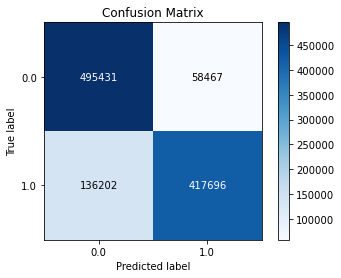

(array([0.78436529, 0.87721222]), array([0.89444446, 0.75410274]), array([0.83579594, 0.81101216]), array([553898, 553898]))


In [34]:
# An example of confusion matrix

import scikitplot as skplt
import sklearn
skplt.metrics.plot_confusion_matrix(Tar_bin_test[dfindex].flatten(), np.round(pred_bin[dfindex]).flatten(), normalize=False)
plt.show()
print(sklearn.metrics.precision_recall_fscore_support(Tar_bin_test[dfindex].flatten(), np.round(pred_bin[dfindex]).flatten()))

In [145]:
# Displaying a false positive sample in the next cell.
# In our study, a false positive occurs when the label is [0, 0], meaning it may contain a non-artificial moving source.

pp, pn, np, nn = [], [], [], []
pp_fp = []

for i, e in enumerate(pred_bin):
    pair = e[:2].tolist()
    if pair == [1, 1]:
        pp.append(i)
        if Tar_test[i][:2].tolist() == [0, 0]:
            pp_fp.append(i)
    elif pair == [1, 0]:
        pn.append(i)
    elif pair == [0, 1]:
        np.append(i)
    elif pair == [0, 0]:
        nn.append(i)

0 0
1.0 1.0
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


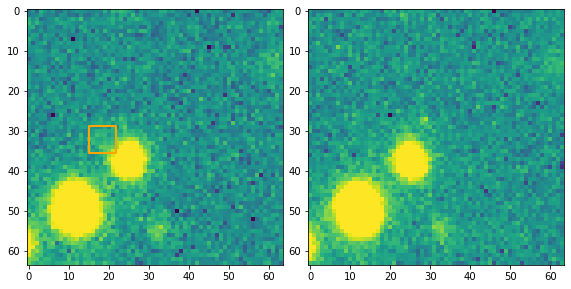

In [152]:
# An example of a pair of sub-images, and its predicted binary classification and the predicted position of a moving object on the image.

n_pic= pp_fp[0]
fig = plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
norm0 = ImageNormalize(Image_test[n_pic,0], interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(Image_test[n_pic,0],norm=norm0)
if Tar_posmag_test[n_pic,0] !=-1:
    plt.scatter(Tar_posmag_test[n_pic,0],Tar_posmag_test[n_pic,1],marker='o', s=700, facecolors='none', edgecolors='red', lw = 2)
plt.scatter(pred_pos[n_pic,0],pred_pos[n_pic,1],marker='s', s=700, facecolors='none', edgecolors='orange', lw = 2)

plt.subplot(2, 2, 2)
norm1 = ImageNormalize(Image_test[n_pic,1], interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(Image_test[n_pic,1],norm=norm1)
if Tar_posmag_test[n_pic,0] !=-1:
    plt.scatter(Tar_posmag_test[n_pic,2],Tar_posmag_test[n_pic,3],marker='o', s=700, facecolors='none', edgecolors='red', lw = 2)
plt.scatter(pred_pos[n_pic,2],pred_pos[n_pic,3],marker='s', s=700, facecolors='none', edgecolors='orange', lw = 2)

print(Tar_test[n_pic][0], Tar_test[n_pic][1])
print(pred_bin[n_pic][0], pred_bin[n_pic][1])
print(Tar_test[n_pic][6], Tar_test[n_pic][7])
plt.tight_layout()
# plt.savefig('Figures/nn.png', dpi=300)